### Load Required Packages

In [32]:
import tensorflow as tf
import numpy as np
import os
import math

from PIL import Image

### Function to Output Image Levels


> Default 512x512 Image Patch level be 9



In [4]:
def log2n(n):
    if n > 1:
        exp_n = 1 + log2n(n / 2)
    else:
        exp_n = 0

    return exp_n

### Convert Input Values into String/Byte Format

In [5]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

### Convert Input Values into Float Format

In [6]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

### Convert Input Values into Integer Format

In [7]:
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

### Extract Patches from Original Input Image, and Write All Necessary Components into TFRECORDS Files

In [8]:
def patch_extract_to_tf(tf_path, input_img_path, height=512, width=512):
    img_level = str(log2n(height))
    # load your input image in
    img = Image.open(input_img_path)
    # get your image name
    img_name = os.path.basename(input_img_path)
    img_name = img_name.split('.')[0]
    imgwidth, imgheight = img.size

    # if your tf_path is not existed, it will create one for you
    if not os.path.exists(os.path.join(tf_path, img_name)):
        os.mkdir(os.path.join(tf_path, img_name))

    # create an empty tfrecord file with the desired file name 
    tf_writer = tf.io.TFRecordWriter(os.path.join(tf_path, img_name, img_name + '_L' + img_level + '.tfrecords'))

    # patch extraction task
    patch_str = list()
    for i in range(0, imgheight, height):
        for j in range(0, imgwidth, width):
            box = (j, i, j + width, i + height)
            image_patch = img.crop(box)
            image_patch_str = image_patch.tobytes()
            patch_str.append(image_patch_str)

    # write the expected components in your final tfrecord files
    for k in range(len(patch_str)):
        img_str = patch_str[k]
        image_name = img_name + 'patch_' + str(k)
        image_format = 'png'
        feature = {'height': _int64_feature(height),
                   'width': _int64_feature(width),
                   'depth': _int64_feature(3),
                   'image/format': _bytes_feature(image_format.encode('utf8')),
                   'image_name': _bytes_feature(image_name.encode('utf8')),
                   'image/encoded': _bytes_feature(img_str)}

        Example = tf.train.Example(features=tf.train.Features(feature=feature))
        Serialized = Example.SerializeToString()
        tf_writer.write(Serialized)

    tf_writer.close()

### Run Patch Extraction to TFRECORD Function

In [11]:
tf_dir = '/content/tf'
b7_dir = '/content/img/b007.tif'
is6_dir = '/content/img/is006.tif'
iv17_dir = '/content/img/iv017.tif'
n50_dir = '/content/img/n050.tif'

In [15]:
patch_extract_to_tf(tf_path=tf_dir, 
                    input_img_path=b7_dir, 
                    height=512, 
                    width=512)

### Function to Examine Output TFRECODS Files

In [16]:
def get_data_from_tf(tf_path):
    feature = {'height': tf.io.FixedLenFeature([], tf.int64),
               'width': tf.io.FixedLenFeature([], tf.int64),
               'depth': tf.io.FixedLenFeature([], tf.int64),
               'image/format': tf.io.FixedLenFeature([], tf.string),
               'image_name': tf.io.FixedLenFeature([], tf.string),
               'image/encoded': tf.io.FixedLenFeature([], tf.string)}

    tfrecord_dataset = tf.data.TFRecordDataset(tf_path)

    def _parse_image_function(key):
        return tf.io.parse_single_example(key, feature)

    img_dataset = tfrecord_dataset.map(_parse_image_function)

    images = list()
    image_names = list()
    image_formats = list()
    image_height = list()
    image_width = list()
    image_depth = list()

    for tfrecord_value in img_dataset:
        height = tfrecord_value['height']
        width = tfrecord_value['width']
        depth = tfrecord_value['depth']
        format = tfrecord_value['image/format']
        name = tfrecord_value['image_name']
        img = tfrecord_value['image/encoded']

        images.append(img)
        image_names.append(name)
        image_formats.append(format)
        image_height.append(height)
        image_width.append(width)
        image_depth.append(depth)

    return images, image_names, image_formats, image_height, image_width, image_depth

### The following function allow you to check your output image patches

In [17]:
def check_img_patch(patch_list):
  img_patches = list()
  for i in patch_list:
    img_patch = Image.frombytes('RGB', (512, 512), i.numpy())
    img_patches.append(img_patch)

  return img_patches

### Examine your ourtput tfrecords

In [23]:
b7_tf='/content/tf/b007/b007_L9.tfrecords'
is6_tf='/content/tf/is006/is006_L9.tfrecords'
iv17_tf='/content/tf/iv017/iv017_L9.tfrecords'
n50_tf='/content/tf/n050/n050_L9.tfrecords'

In [24]:
images,image_names,image_formats, image_height, image_width, image_depth = get_data_from_tf(tf_path=iv17_tf)

#### Examine Image Patches

In [25]:
image_patches = check_img_patch(images)

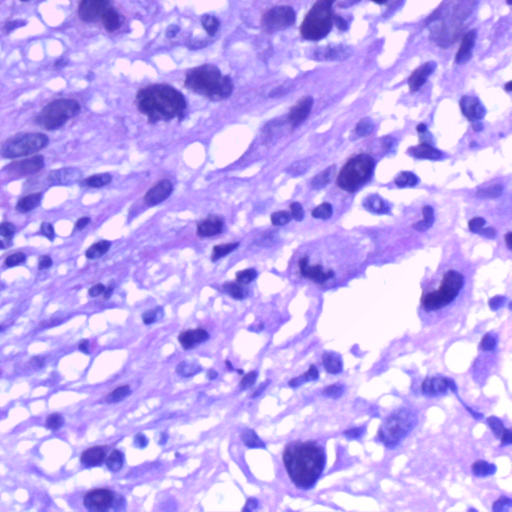

In [26]:
image_patches[11]

#### Examine Image Names

In [27]:
image_names

[<tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_0'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_1'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_2'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_3'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_4'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_5'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_6'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_7'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_8'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_9'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_10'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'iv017patch_11'>]

#### Examine Image Height

In [28]:
image_height

[<tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>]

#### Examine Image Width

In [29]:
image_width

[<tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>,
 <tf.Tensor: shape=(), dtype=int64, numpy=512>]

#### Examine Image Depth

In [30]:
image_depth

[<tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>]

#### Examine Image Formats

In [31]:
image_formats

[<tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'png'>]